In [194]:
import pandas as pd 
import numpy as np
import matplotlib as mpl 
import matplotlib.pyplot as plt
from matplotlib.patches import Patch, Rectangle
from selenobot.files import XMLFile
from selenobot.utils import seed 
from selenobot.datasets import Dataset, get_dataloader
from selenobot.utils import digitize, groupby, sample
import os
import sys
from typing import List, Tuple, Dict
import scipy.stats
import sklearn.neighbors
from tqdm import tqdm
from scipy.stats import false_discovery_control, mannwhitneyu

import warnings 
warnings.simplefilter('ignore')

%load_ext autoreload
%autoreload 2

colors = {1:'tab:red', 2:'tab:blue', 0:'gray'}
plt.rcParams['font.family'] = 'Arial'


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def plot_length_distribution(metadata_dfs:List[pd.DataFrame], ax:plt.Axes=None, bins:int=25, density:bool=False):

    n_dropped, lengths = 0, []
    for df in metadata_dfs:
        nans = df.seq.isnull()
        n_dropped += nans.sum()
        lengths.append(df[~nans].seq.apply(len).values)
    print(f'plot_length_distribution: Dropped {n_dropped} empty sequences.')

    ax.hist(lengths, density=density, bins=bins, edgecolor='white')
    ax.set_ylabel('density' if density else 'count')
    ax.set_xlabel('length')


In [3]:
train_metadata_df = pd.read_csv('../data/train_metadata.csv', index_col=0)
test_metadata_df = pd.read_csv('../data/test_metadata.csv', index_col=0)
val_metadata_df = pd.read_csv('../data/val_metadata.csv', index_col=0)

metadata_df = pd.concat([train_metadata_df, test_metadata_df, val_metadata_df])
metadata_df = metadata_df[~metadata_df.seq.isnull()]

label_0_metadata_df = metadata_df[metadata_df.label == 0]
label_1_metadata_df = metadata_df[metadata_df.label == 1]
label_2_metadata_df = metadata_df[metadata_df.label == 2]

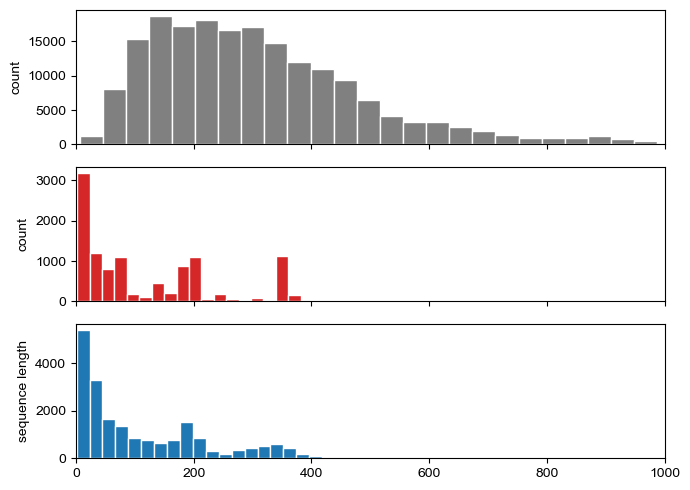

In [4]:
fig, axes = plt.subplots(figsize=(7, 5), nrows=3, sharex=True)

for label, ax in enumerate(axes):
    label_metadata_df = metadata_df[metadata_df.label == label]
    ax.hist(label_metadata_df.seq.apply(len), bins=50, color=colors[label], edgecolor='white')
    ax.set_ylabel('count')
    # ax.set_title(f'label {label} (n={len(label_metadata_df)})')
    ax.set_xlim(xmax=1000, xmin=0)

axes[-1].set_ylabel('sequence length')
plt.tight_layout()
plt.show()

/home/prichter/Documents/selenobot/selenobot/utils.py:54: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sorted_values, sorted_keys = values[sort_idxs], keys[sort_idxs] # Sort the values and keys.
/home/prichter/miniconda3/envs/selenobot/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


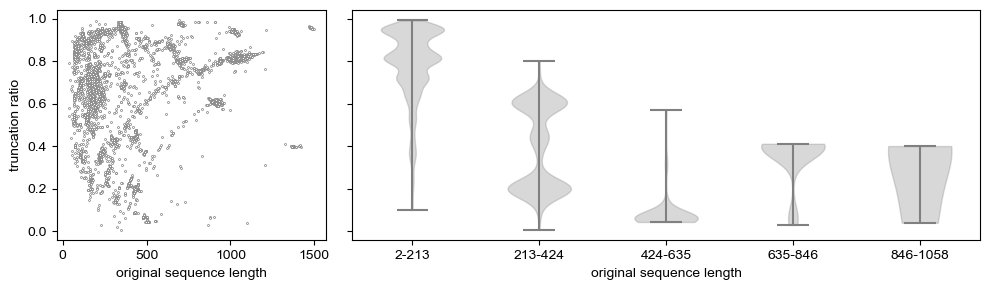

In [5]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 3), width_ratios=[0.3, 0.7], sharey=True)

axes[0].set_xlabel('original sequence length')
axes[0].set_ylabel('truncation ratio')
axes[0].scatter(label_1_metadata_df.original_length, label_1_metadata_df.truncation_ratio, s=2, facecolor='white', linewidth=0.5, edgecolor='gray')

n_bins = 5
hist, bin_edges = np.histogram(label_1_metadata_df.seq.apply(len), bins=n_bins)
bin_labels, bin_names = digitize(label_1_metadata_df.seq.apply(len), bin_edges)
binned_ratios = groupby(label_1_metadata_df.truncation_ratio, bin_labels)

data = [np.sort(binned_ratios[bin_label]) for bin_label in range(1, n_bins + 1)]
violinplot = axes[1].violinplot(data, orientation='vertical')

for body in violinplot['bodies']:
    body.set_facecolor('gray')
    body.set_edgecolor('gray')
violinplot['cbars'].set_edgecolor('gray')
violinplot['cmins'].set_edgecolor('gray')
violinplot['cmaxes'].set_edgecolor('gray')

axes[1].set_xticks(np.arange(n_bins) + 1, bin_names)
axes[1].set_xlabel('original sequence length')

plt.tight_layout()
plt.show()

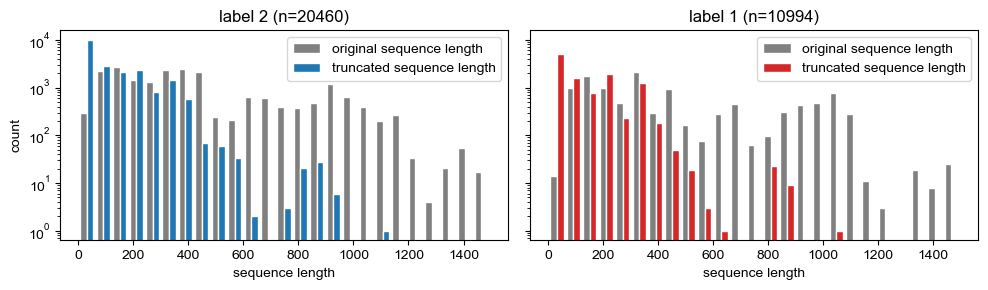

In [6]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 3), sharey=True)

axes[0].hist((label_2_metadata_df.original_length, label_2_metadata_df.seq.apply(len)), bins=25, edgecolor='white', color=['gray', colors[2]])
axes[0].set_yscale('log')
axes[0].set_ylabel('count')
axes[0].set_xlabel('sequence length')
axes[0].legend(['original sequence length', 'truncated sequence length'])
axes[0].set_title(f'label 2 (n={len(label_2_metadata_df)})')

axes[1].hist((label_1_metadata_df.original_length, label_1_metadata_df.seq.apply(len)), bins=25, edgecolor='white', color=['gray', colors[1]])
axes[1].set_yscale('log')
# axes[1].set_ylabel('count')
axes[1].set_xlabel('sequence length')
axes[1].legend(['original sequence length', 'truncated sequence length'])
axes[1].set_title(f'label 1 (n={len(label_1_metadata_df)})')

plt.tight_layout()
plt.show()

In [183]:
# Figure 4

# Want to show taxa which are potentially enriched for truncated selenoproteins. I will do this 
# like how Josh did Figure 2 in the original manuscript, with log-fold change on the x-axis and significance on the y-axis.

# Want to somehow normalize by how well-studied a taxon is, which I can probably do by looking at SwissProt (i.e. label 0)
# In other words, I want to look at the fraction of selenoproteins relative to total genes from that organism. 

metadata_df_subset = metadata_df.copy()[metadata_df.label.isin([0, 1])]

# entries_per_family = metadata_df_subset.groupby('family').apply(len, include_groups=False)
# mean_entries_per_family = entries_per_family.mean()

# families = entries_per_family[entries_per_family > 10].index
# metadata_df_subset = metadata_df_subset[metadata_df_subset.family.isin(families)]

# families_per_phylum = metadata_df_subset.groupby('phylum').apply(lambda x : len(x.family.unique()), include_groups=False)
# mean_families_per_phylum = families_per_phylum.mean()

# phyla = families_per_phylum[families_per_phylum > 5].index
# metadata_df_subset = metadata_df_subset[metadata_df_subset.phylum.isin(phyla)]

min_n = 10
ns = metadata_df_subset.groupby('phylum').apply(lambda df : len(df.species.unique()), include_groups=False)
phyla = n_values[ns > min_n].index
filter_ = metadata_df_subset.phylum.isin(phyla)

p_with_phylum = int(100 * (~metadata_df_subset.phylum.isnull()).sum() / len(metadata_df_subset))
p_with_species = int(100 * (~metadata_df_subset.phylum.isnull()).sum() / len(metadata_df_subset)) 

print(f'{p_with_phylum}% of the sequences have an assigned phylum.')
print(f'{p_with_species}% of the sequences have an assigned species.', end='\n\n')

print(f'Using {len(phyla)} phyla out of {len(ns)}, which meet the {min_n} species threshold.')
print(f'Dropping {len(metadata_df) - filter_.sum()} out of {len(metadata_df_subset)} sequences from the metadata.', end='\n\n')

metadata_df_subset = metadata_df_subset[filter_]

get_dist = lambda df : df.groupby('species').apply(lambda df_ : df_.label.sum() / len(df_), include_groups=False)

ref_dist = get_dist(metadata_df_subset)
fig_4_df = list()
for phylum, phylum_df in tqdm(metadata_df_subset.groupby('phylum'), desc='Calculating Mann-Whitney U test statistics...'):
    phylum_dist = get_dist(phylum_df)
    mwu_result = mannwhitneyu(phylum_dist.values.ravel(), ref_dist.values.ravel(), method='auto')
    
    row = dict()
    row['phylum'] = phylum 
    row['n'] = len(phylum_df.species.unique())
    row['p'] = mwu_result.pvalue
    row['mean'] = phylum_dist.mean()
    row['stat'] = mwu_result.statistic
    fig_4_df.append(row)

fig_4_df = pd.DataFrame(fig_4_df).set_index('phylum') 

cmap = plt.get_cmap('coolwarm')

fig_4_df['q'] = false_discovery_control(fig_4_df.p.values.ravel())
fig_4_df['log10_mean'] = np.log10(fig_4_df['mean'].values.astype(float))
epsilon = fig_4_df.q[fig_4_df.q > 0].min() / 10 # Choose an epsilon value to add to the zero q values.
fig_4_df['log10_q'] = np.log10(fig_4_df.q + epsilon)
fig_4_df['log10_n'] = np.log10(fig_4_df.n)
fig_4_df['color'] = [cmap(n / fig_4_df.log10_n.max()) for n in fig_4_df.log10_n]

fig_4_df.to_csv('datasets_fig_4.csv')
print('\nSaved Figure 4 data to ./datasets_fig_4.csv.')


98% of the sequences have an assigned phylum.
98% of the sequences have an assigned species.

Using 72 phyla out of 115, which meet the 10 species threshold.
Dropping 23570 out of 200774 sequences from the metadata.



Calculating Mann-Whitney U test statistics...: 100%|██████████| 72/72 [00:24<00:00,  2.90it/s]


Saved Figure 4 data to ./dataset_fig_4.csv.


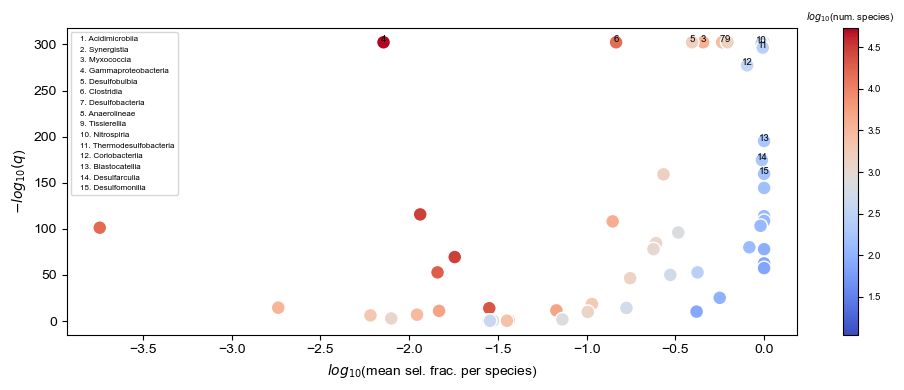

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))

scatter = ax.scatter(fig_4_df.log10_mean, -fig_4_df.log10_q, color='gray', facecolor=fig_4_df.color, edgecolor='white', s=100)

ax.set_ylabel('$-log_{10}(q$)')
ax.set_xlabel('$log_{10}$(mean sel. frac. per species)')

fig_4_df = fig_4_df.sort_values(by='q', ascending=True)
annot_df = pd.DataFrame(index=fig_4_df.index[:15])
annot_df['x'] = fig_4_df.log10_mean.values[:15]
annot_df['y'] = -fig_4_df.log10_q.values[:15]
buffer = 0.015
is_close = lambda x, y, df : (np.sum(np.abs(df.x.values - x) < buffer) > 1) and (np.sum(np.abs(df.y.values - y) < buffer) > 1)
labels = list()
for i, row in enumerate(annot_df.itertuples()):
    labels.append(f'{i + 1}. {row.Index}')
    if not is_close(row.x, row.y, annot_df):
        ax.text(row.x, row.y, str(i + 1), fontsize='x-small', horizontalalignment='center')

norm = mpl.colors.Normalize(vmin=fig_4_df.log10_n.min(), vmax=fig_4_df.log10_n.max())
scalar_mappable = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(scalar_mappable, ax=ax, cmap=cmap)
cbar.ax.set_title('$log_{10}$(num. species)', fontsize='x-small')
cbar.ax.tick_params(labelsize='x-small')

handles = [Patch(color='none') for _ in range(len(labels))]
ax.legend(handles=handles, labels=labels, handlelength=0, fontsize='xx-small')


plt.tight_layout()
plt.show()


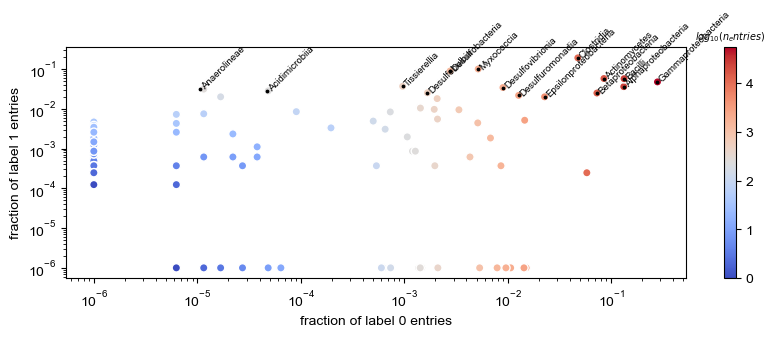

In [ ]:
fig, ax = plt.subplots(figsize=(10, 3))

n_label_0_per_phylum_df = pd.DataFrame(label_0_metadata_df.groupby('phylum').apply(len, include_groups=False), columns=['n_label_0'])
n_label_1_per_phylum_df = pd.DataFrame(label_1_metadata_df.groupby('phylum').apply(len, include_groups=False), columns=['n_label_1'])
df = n_label_0_per_phylum_df.merge(n_label_1_per_phylum_df, left_index=True, right_index=True, how='outer').fillna(0)
df['fraction_label_0']  = df.n_label_0 / df.n_label_0.sum()
df['fraction_label_1'] = df.n_label_1 / df.n_label_1.sum()
df['n_entries'] = df.n_label_0 + df.n_label_1
df['log10_n_entries'] = np.log10(df.n_entries)
cmap = plt.get_cmap('coolwarm')
df['color'] = [cmap(n / df.log10_n_entries.max()) for n in df.log10_n_entries]

ax.scatter(df.fraction_label_0 + 1e-6, df.fraction_label_1 + 1e-6, edgecolor='white', color=df.color) # Add small values so the zeros are included with log scale. 
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel('fraction of label 1 entries')
ax.set_xlabel('fraction of label 0 entries')

norm = mpl.colors.Normalize(vmin=df.log10_n_entries.min(), vmax=df.log10_n_entries.max())
scalar_mappable = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(scalar_mappable, ax=ax, cmap=cmap)
cbar.ax.set_title('$log_{10}(n_entries)$', fontsize='x-small')

for row in df.sort_values(by='fraction_label_1', ascending=False).iloc[:15].itertuples():
    x = row.fraction_label_0
    y = row.fraction_label_1
    ax.scatter([x], [y], color='black', s=3)
    ax.text(x, y, row.Index, fontsize='x-small', horizontalalignment='left', rotation=45)


plt.show()


In [147]:
n_label_per_phylum_df

,n_label_0,n_label_1
phylum,,
Acidimicrobiia,0.000047,0.028245
Acidithiobacillia,0.001408,0.000000
Actinomycetes,0.085230,0.057841
Alphaproteobacteria,0.132597,0.036105
Anaerolineae,0.000011,0.031315
...,...,...
Thermotogae,0.009621,0.000000
Tissierellia,0.000965,0.036841
Verrucomicrobiae,0.000733,0.008351
